In [ ]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import psutil
import gzip

ModuleNotFoundError: No module named 'scipy'

In [2]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()
print("Tables in the database:")
for table in tables:
    print(table[0])
conn.close()


Tables in the database:
sites
sqlite_sequence
alexa_ranks
policy_texts
policy_htmls
policy_reader_view_htmls
policy_snapshots


In [3]:
conn = sqlite3.connect('/app/Data/release_db.sqlite')
cursor = conn.cursor()

# Get row counts for each table
cursor.execute("SELECT COUNT(*) FROM policy_texts")
policy_texts_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM sites")
sites_count = cursor.fetchone()[0]

cursor.execute("SELECT COUNT(*) FROM policy_snapshots")
snapshots_count = cursor.fetchone()[0]

conn.close()

print(f"policy_texts rows: {policy_texts_count}")
print(f"sites rows: {sites_count}")
print(f"policy_snapshots rows: {snapshots_count}")

policy_texts rows: 333986
sites rows: 130620
policy_snapshots rows: 1071487


In [4]:
def load_readability_data(chunksize=50000):
    conn = sqlite3.connect('/app/Data/release_db.sqlite')
    
    query = """
    SELECT 
        s.domain,
        s.categories,
        pt.flesch_kincaid,
        pt.smog,
        pt.flesch_ease,
        ps.year,
        ps.phase
    FROM 
        sites s
    JOIN 
        policy_snapshots ps ON s.id = ps.site_id
    JOIN 
        policy_texts pt ON ps.policy_text_id = pt.id
    """
    
    chunks = []
    for chunk in pd.read_sql_query(query, conn, chunksize=chunksize):
        print(f"Loaded chunk of size: {len(chunk)}")
        chunks.append(chunk)
        
    conn.close()
    
    return pd.concat(chunks, ignore_index=True)

# Load the data
df = load_readability_data()

print(f"Total rows loaded: {len(df)}")
print(df.head())


Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 50000
Loaded chunk of size: 21487
Total rows loaded: 1071487
         domain                categories  flesch_kincaid       smog  \
0  docusign.com  business;informationtech       14.938384  18.351184   
1  docusign.com  business;informationtech       13.762202  18.171460   
2  docusign.com  business;informationtech       13.640407  18.062587   
3  docusign.com  business;informationtech       13.640407  18.062587 

In [5]:
# Basic statistics
print(df.describe())


       flesch_kincaid           smog          year
count    1.044684e+06  678307.000000  1.071487e+06
mean     1.293594e+01      15.169765  2.013036e+03
std      1.861677e+00       1.559115  4.233258e+00
min      2.913221e-01       5.461319  1.997000e+03
25%      1.175368e+01      14.167174  2.011000e+03
50%      1.289556e+01      15.157563  2.014000e+03
75%      1.409708e+01      16.156166  2.016000e+03
max      4.824111e+01      24.248240  2.019000e+03


In [6]:
# Check for missing values
print(df.isnull().sum())


domain                 0
categories             0
flesch_kincaid     26803
smog              393180
flesch_ease        26803
year                   0
phase                  0
dtype: int64


In [7]:
# Correlation between readability scores
correlation_matrix = df[['flesch_kincaid', 'smog', 'flesch_ease']].corr()
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                flesch_kincaid      smog
flesch_kincaid        1.000000  0.876276
smog                  0.876276  1.000000


/tmp/ipykernel_65296/4022802289.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df[['flesch_kincaid', 'smog', 'flesch_ease']].corr()


In [8]:
# Average readability scores by year
yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog', 'flesch_ease']].mean()
print("Yearly Averages:")
print(yearly_averages)


Yearly Averages:
      flesch_kincaid       smog
year                           
1997       13.112056  14.440260
1998       12.720505  14.385156
1999       12.358348  14.386897
2000       12.155811  14.340922
2001       12.306016  14.540814
2002       12.381935  14.662638
2003       12.403658  14.692982
2004       12.461684  14.771178
2005       12.529386  14.823040
2006       12.599056  14.895032
2007       12.710667  15.017304
2008       12.770552  15.084850
2009       12.853273  15.138784
2010       12.898256  15.172349
2011       12.873741  15.186714
2012       12.894060  15.158112
2013       12.932845  15.170486
2014       12.977552  15.193465
2015       13.013354  15.213573
2016       13.027146  15.224852
2017       13.098925  15.259638
2018       13.142320  15.296959
2019       13.167947  15.261124


/tmp/ipykernel_65296/2084141685.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  yearly_averages = df.groupby('year')[['flesch_kincaid', 'smog', 'flesch_ease']].mean()


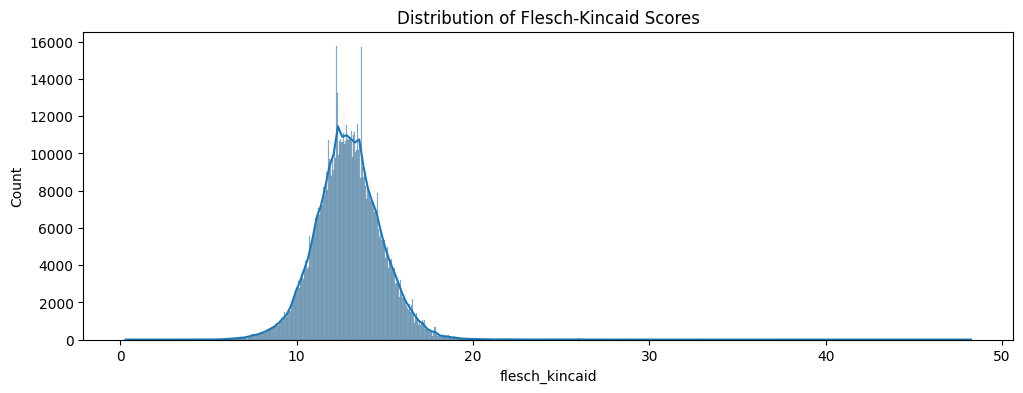

In [9]:
plt.figure(figsize=(12, 4))
sns.histplot(df['flesch_kincaid'], kde=True)
plt.title('Distribution of Flesch-Kincaid Scores')
plt.show()

# Checking out the "Tracking the Trackers" data

In [10]:
# Load the index file. This one has info on the website's domain name + a unique identifier for each domain
df_index = pd.read_csv('/app/Data/pld-index.tsv.gz', sep='\t', names=['domain', 'domain_id'], compression='gzip')

# Load the tracking file. This one has the unique ID and the ID of a third-party tracker assoc. w that website
df_track = pd.read_csv('/app/Data/tracking-graph.tsv.gz', sep='\t', names=['domain_id', 'tracking_domain_id'], compression='gzip')
# Something to note here that I initially found a bit confusing is that the third-party data sharing info is not a 
# single number, but rather a relationship b/w websites and trackers. So each row in df_track is a connection b/w
# a website and a third-party tracker

print("Index file shape:", df_index.shape)
print("Tracking file shape:", df_track.shape)

Index file shape: (46269087, 2)
Tracking file shape: (36982655, 2)


In [11]:
df_tracking_merged = pd.merge(df_track, df_index, on='domain_id', how='left')
print("Merged tracking data shape:", df_tracking_merged.shape)
print(df_tracking_merged.head())

Merged tracking data shape: (36982655, 3)
   domain_id  tracking_domain_id          domain
0   39156864            42889919   tutengine.com
1   39156864            15964105   tutengine.com
2   39156994             2283834  tuthienbao.com
3   39156994            15964105  tuthienbao.com
4   39156994            39260173  tuthienbao.com


In [12]:
readability_domains = set(df['domain'])
tracking_domains = set(df_tracking_merged['domain'])

common_domains = readability_domains.intersection(tracking_domains)

print(f"Number of domains in readability data: {len(readability_domains)}")
print(f"Number of domains in tracking data: {len(tracking_domains)}")
print(f"Number of common domains: {len(common_domains)}")


Number of domains in readability data: 130620
Number of domains in tracking data: 18782899
Number of common domains: 71663


In [13]:
# Count the number of trackers for each domain
tracker_counts = df_tracking_merged.groupby('domain').size().reset_index(name='tracker_count')

# Merge with readability data
df_combined = pd.merge(df, tracker_counts, on='domain', how='left')

# Fill NaN values in tracker_count with 0 (for websites with no tracking data)
df_combined['tracker_count'] = df_combined['tracker_count'].fillna(0)

print("Combined data shape:", df_combined.shape)
print(df_combined.head())


Combined data shape: (1071487, 8)
         domain                categories  flesch_kincaid       smog  \
0  docusign.com  business;informationtech       14.938384  18.351184   
1  docusign.com  business;informationtech       13.762202  18.171460   
2  docusign.com  business;informationtech       13.640407  18.062587   
3  docusign.com  business;informationtech       13.640407  18.062587   
4  docusign.com  business;informationtech       13.762202  18.171460   

  flesch_ease  year phase  tracker_count  
0   difficult  2003     B           12.0  
1   difficult  2004     B           12.0  
2   difficult  2006     B           12.0  
3   difficult  2006     A           12.0  
4   difficult  2004     A           12.0  


In [14]:
# Correlation between readability scores and tracker count
correlation = df_combined[['flesch_kincaid', 'smog', 'flesch_ease', 'tracker_count']].corr()
print("Correlation matrix:")
print(correlation)

Correlation matrix:
                flesch_kincaid      smog  tracker_count
flesch_kincaid        1.000000  0.876276       0.019314
smog                  0.876276  1.000000       0.014147
tracker_count         0.019314  0.014147       1.000000


/tmp/ipykernel_65296/104042176.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = df_combined[['flesch_kincaid', 'smog', 'flesch_ease', 'tracker_count']].corr()


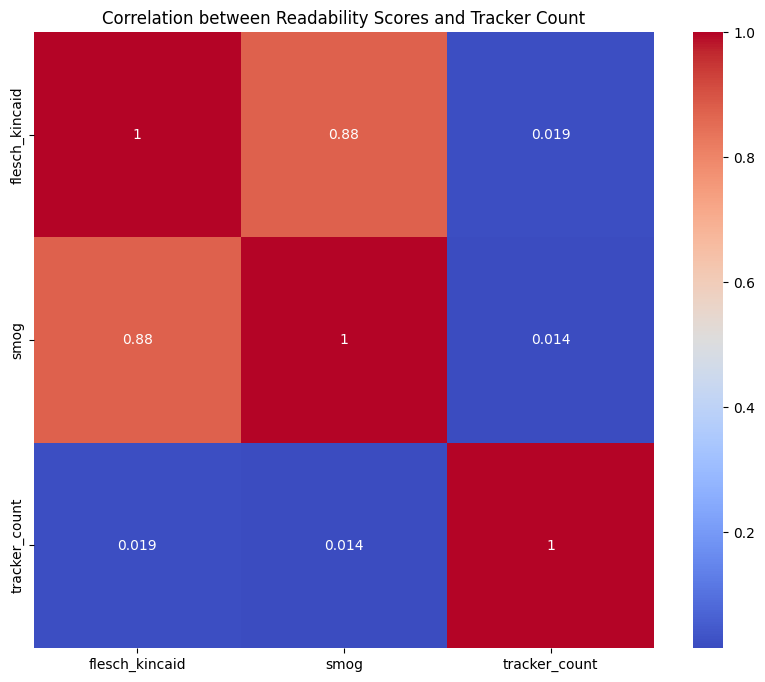

In [15]:
# Visualize the correlation
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation between Readability Scores and Tracker Count')
plt.show()

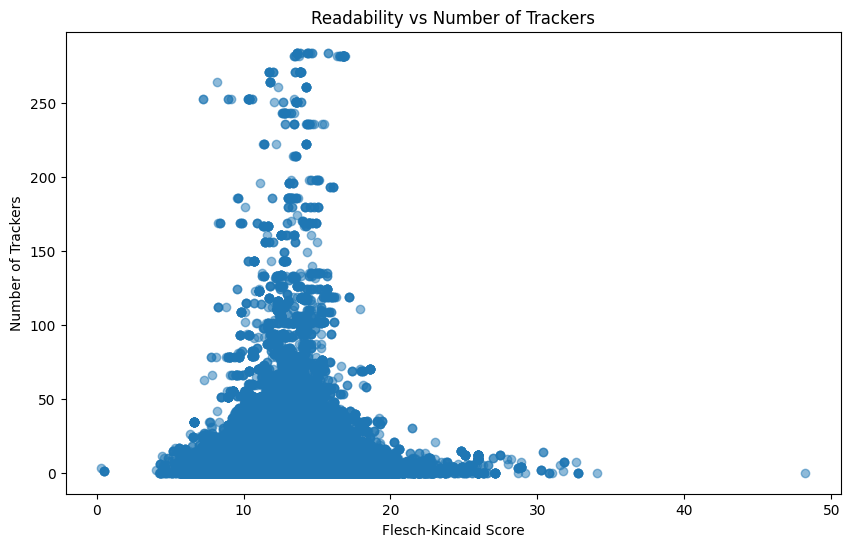

In [16]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_combined['flesch_kincaid'], df_combined['tracker_count'], alpha=0.5)
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers')
plt.show()

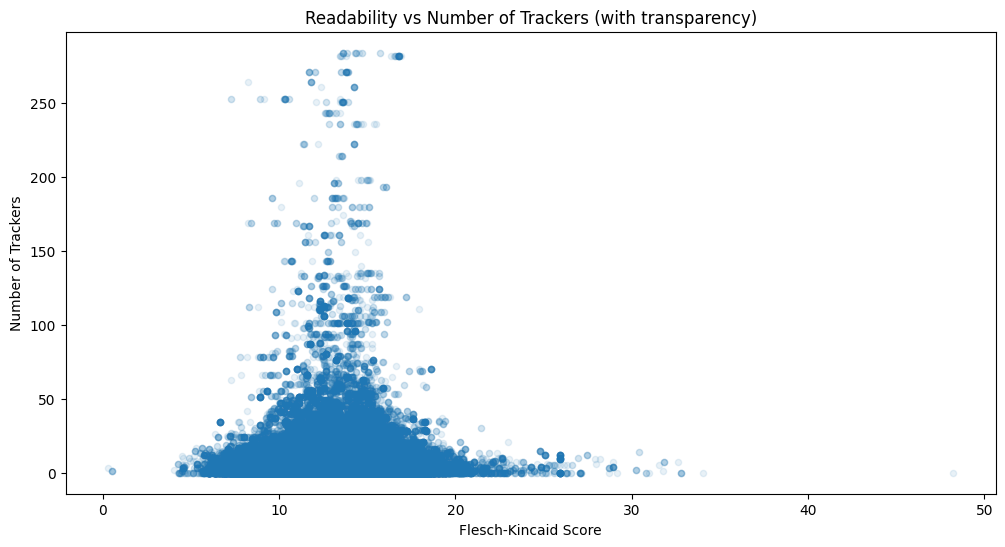

In [ ]:
# Option 1: Add transparency to see density
plt.figure(figsize=(12, 6))
plt.scatter(df_combined['flesch_kincaid'], df_combined['tracker_count'], from scipy import stats
           alpha=0.1, # Make points transparent
           s=20)     # Adjust point size
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers (with transparency)')
plt.show()


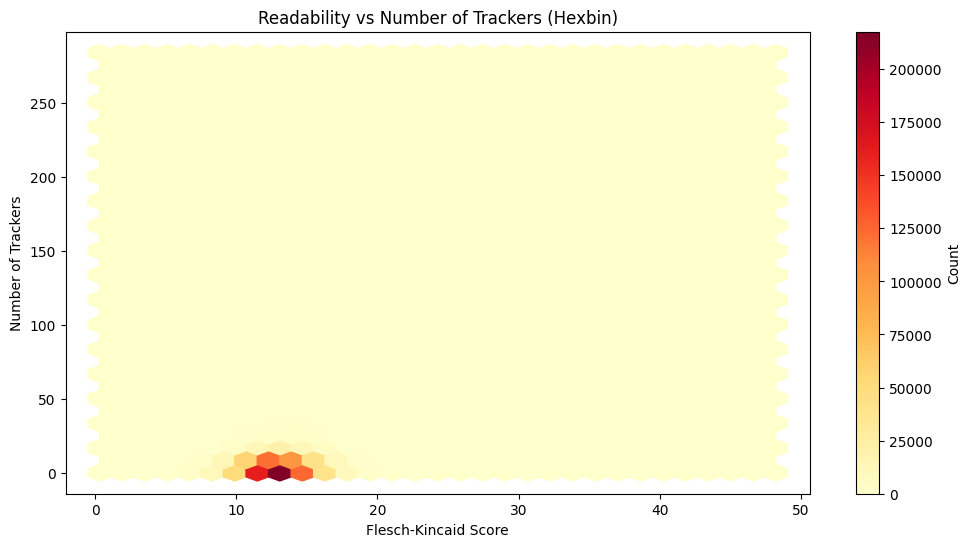

In [18]:
# Option 2: Use a hexbin plot to show density
plt.figure(figsize=(12, 6))
plt.hexbin(df_combined['flesch_kincaid'], df_combined['tracker_count'], 
           gridsize=30, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers (Hexbin)')
plt.show()

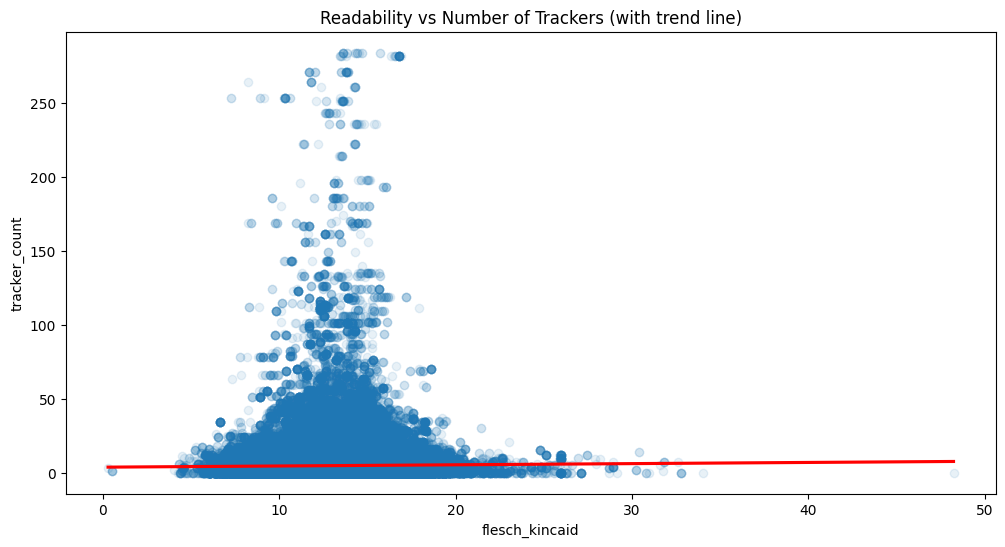

In [19]:
# Option 3: Add a trend line
plt.figure(figsize=(12, 6))
sns.regplot(data=df_combined, x='flesch_kincaid', y='tracker_count',
            scatter_kws={'alpha':0.1}, 
            line_kws={'color': 'red'})
plt.title('Readability vs Number of Trackers (with trend line)')
plt.show()

In [20]:
# Count how many websites have 0 trackers
zero_trackers = len(df_combined[df_combined['tracker_count'] == 0])
total_websites = len(df_combined)

print(f"Websites with 0 trackers: {zero_trackers} out of {total_websites}")
print(f"Percentage: {(zero_trackers/total_websites)*100:.2f}%")

# Look at the distribution of tracker counts
print("\nTracker count distribution:")
print(df_combined['tracker_count'].describe())

# Check how many were originally NaN before we filled with 0
original_nans = df_combined['tracker_count'].isna().sum()
print(f"\nOriginal NaN values: {original_nans}")

Websites with 0 trackers: 275388 out of 1071487
Percentage: 25.70%

Tracker count distribution:
count    1.071487e+06
mean     4.683598e+00
std      7.703006e+00
min      0.000000e+00
25%      0.000000e+00
50%      3.000000e+00
75%      6.000000e+00
max      2.840000e+02
Name: tracker_count, dtype: float64

Original NaN values: 0


In [22]:
# Create a new dataframe without the 0 tracker websites
df_filtered = df_combined[df_combined['tracker_count'] > 0]

print(f"Original dataset size: {len(df_combined)}")
print(f"Dataset size after removing 0 trackers: {len(df_filtered)}")
print(f"Removed {len(df_combined) - len(df_filtered)} entries")

# Look at the new distribution
print("\nNew tracker count distribution:")
print(df_filtered['tracker_count'].describe())

Original dataset size: 1071487
Dataset size after removing 0 trackers: 796099
Removed 275388 entries

New tracker count distribution:
count    796099.000000
mean          6.303756
std           8.345595
min           1.000000
25%           2.000000
50%           5.000000
75%           8.000000
max         284.000000
Name: tracker_count, dtype: float64


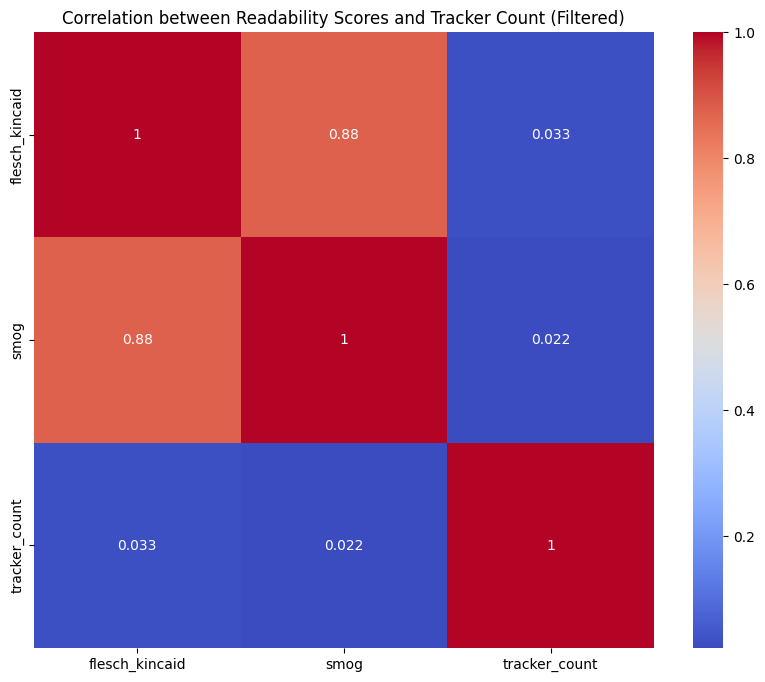

In [23]:
# New correlation matrix
correlation_filtered = df_filtered[['flesch_kincaid', 'smog', 'tracker_count']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_filtered, annot=True, cmap='coolwarm')
plt.title('Correlation between Readability Scores and Tracker Count (Filtered)')
plt.show()

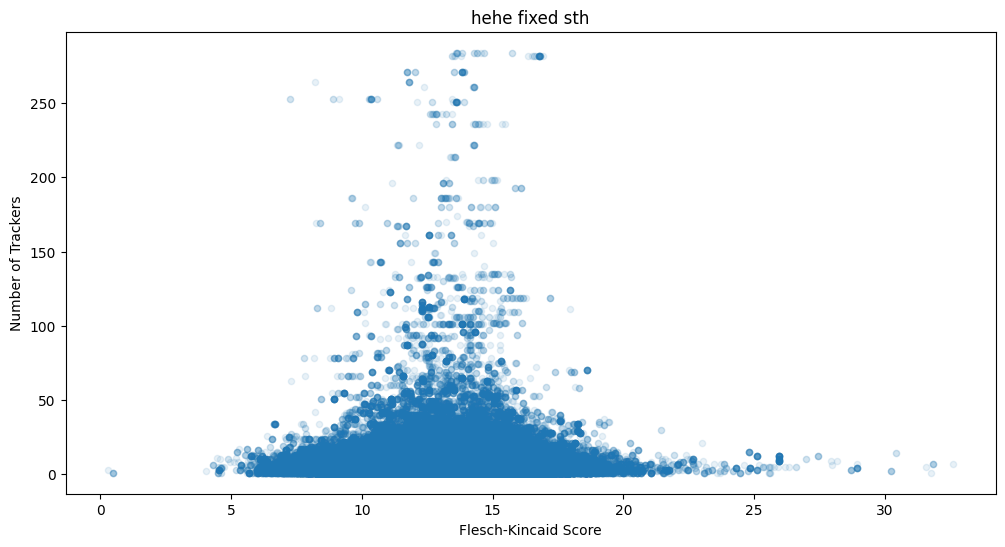

In [ ]:
# New scatter plotfrom scipy import stats
plt.figure(figsize=(12, 6))
plt.scatter(df_filtered['flesch_kincaid'], df_filtered['tracker_count'], 
           alpha=0.1, s=20)
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('hehe fixed sth')
plt.show()

In [26]:
# Verify our filtering worked
print("Number of websites with 0 trackers:", len(df_filtered[df_filtered['tracker_count'] == 0]))

# Look at the minimum tracker count
print("\nMinimum tracker count:", df_filtered['tracker_count'].min())

# Look at distribution of low tracker counts (e.g., 0-5)
print("\nDistribution of low tracker counts:")
print(df_filtered['tracker_count'].value_counts().sort_index().head())


Number of websites with 0 trackers: 0

Minimum tracker count: 1.0

Distribution of low tracker counts:
1.0    108112
2.0    100454
3.0     95129
4.0     85667
5.0     76403
Name: tracker_count, dtype: int64


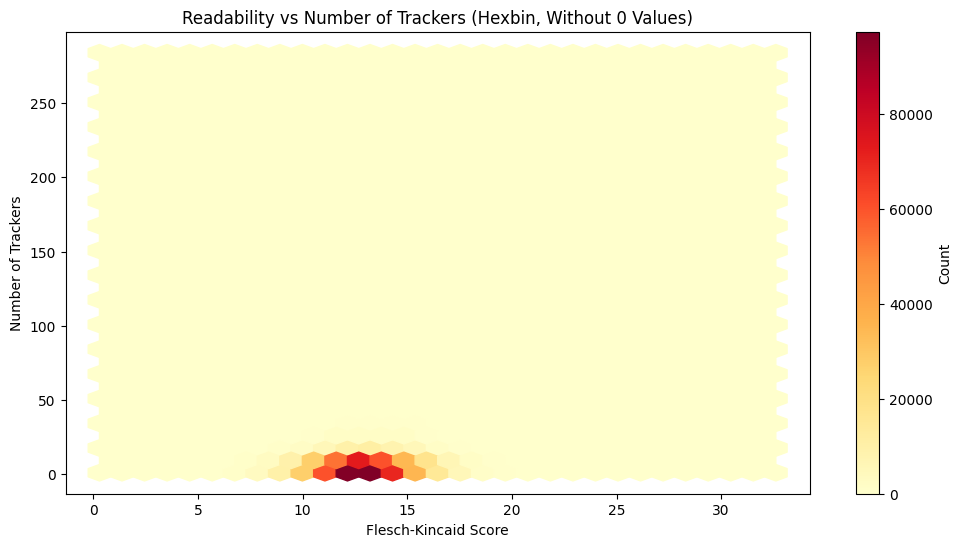

In [25]:
# Hexbin plot for better visualization of density
plt.figure(figsize=(12, 6))
plt.hexbin(df_filtered['flesch_kincaid'], df_filtered['tracker_count'], 
           gridsize=30, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.title('Readability vs Number of Trackers (Hexbin, Without 0 Values)')
plt.show()

In [28]:
def is_social_media(domain):
    social_media_keywords = ['facebook', 'twitter', 'instagram', 'linkedin', 
                           'tiktok', 'youtube', 'pinterest', 'snapchat', 
                           'reddit', 'tumblr']
    return any(keyword in domain.lower() for keyword in social_media_keywords)

# Add a new column for social media status
df_filtered['is_social_media'] = df_filtered['domain'].apply(is_social_media)


/tmp/ipykernel_65296/2313329348.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_social_media'] = df_filtered['domain'].apply(is_social_media)


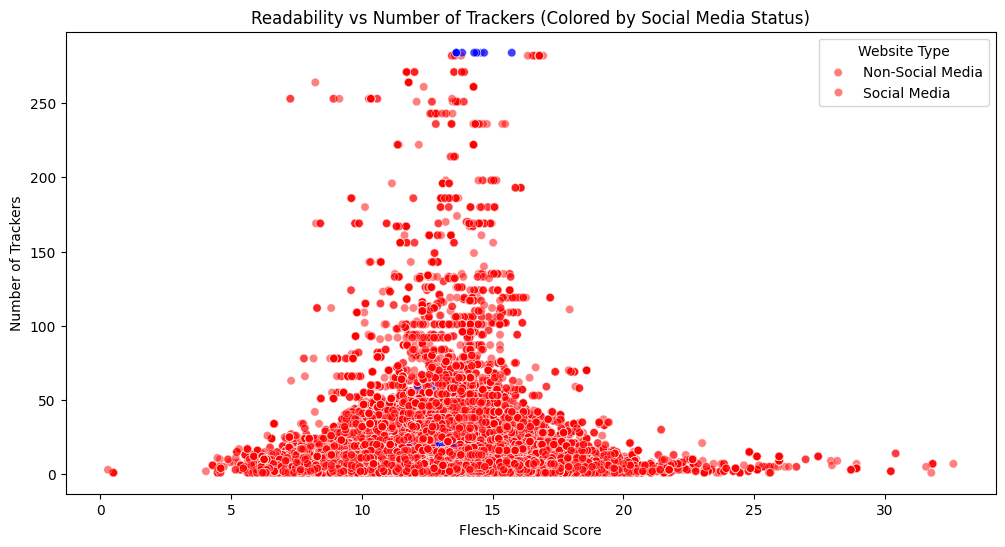


Summary by website type:
                tracker_count               flesch_kincaid       
                        count   mean median           mean median
is_social_media                                                  
False                  795536   6.30    5.0          12.91  12.87
True                      563  14.66    4.0          12.53  12.89


In [29]:
plt.figure(figsize=(12, 6))

# Create scatter plot with two colors
sns.scatterplot(data=df_filtered, 
                x='flesch_kincaid', 
                y='tracker_count',
                hue='is_social_media',
                alpha=0.5,
                palette=['red', 'blue'])

plt.title('Readability vs Number of Trackers (Colored by Social Media Status)')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.legend(title='Website Type', 
          labels=['Non-Social Media', 'Social Media'])

plt.show()

# Print some statistics
print("\nSummary by website type:")
print(df_filtered.groupby('is_social_media').agg({
    'tracker_count': ['count', 'mean', 'median'],
    'flesch_kincaid': ['mean', 'median']
}).round(2))


In [31]:
# Split all categories and get unique values
all_categories = set()
for cats in df_filtered['categories'].dropna():
    all_categories.update(cats.split(';'))

print("All unique individual categories:")
print(sorted(all_categories))


All unique individual categories:
['', 'adult', 'advertising', 'alcoholandtobacco', 'blogsandpersonal', 'business', 'chatandmessaging', 'contentserver', 'deceptive', 'drugs', 'economyandfinance', 'education', 'entertainment', 'foodandrecipes', 'gambling', 'games', 'hacking', 'health', 'humor', 'illegalcontent', 'informationtech', 'jobrelated', 'malicious', 'mediasharing', 'messageboardsandforums', 'newsandmedia', 'parked', 'personals', 'proxyandfilteravoidance', 'realestate', 'religion', 'searchenginesandportals', 'shopping', 'socialnetworking', 'sports', 'streamingmedia', 'translators', 'travel', 'uncategorized', 'vehicles', 'virtualreality', 'weapons']


In [32]:
def is_social_networking(categories):
    if pd.isna(categories):
        return False
    # Split categories and check if 'socialnetworking' is one of them
    category_list = categories.split(';')
    return 'socialnetworking' in category_list

# Create new column
df_filtered['is_social'] = df_filtered['categories'].apply(is_social_networking)

# Print some statistics
print("\nNumber of websites by type:")
print(df_filtered['is_social'].value_counts())

# Print examples of social networking sites
print("\nExample social networking websites:")
print(df_filtered[df_filtered['is_social']]['domain'].head())



Number of websites by type:
False    795824
True        275
Name: is_social, dtype: int64

Example social networking websites:
11759          tumblr.com
39296         groupme.com
47222    exporttrader.com
47223    exporttrader.com
47224    exporttrader.com
Name: domain, dtype: object


/tmp/ipykernel_65296/209432446.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['is_social'] = df_filtered['categories'].apply(is_social_networking)


/tmp/ipykernel_65296/750659705.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['category_count'] = df_filtered['categories'].str.count(';') + 1


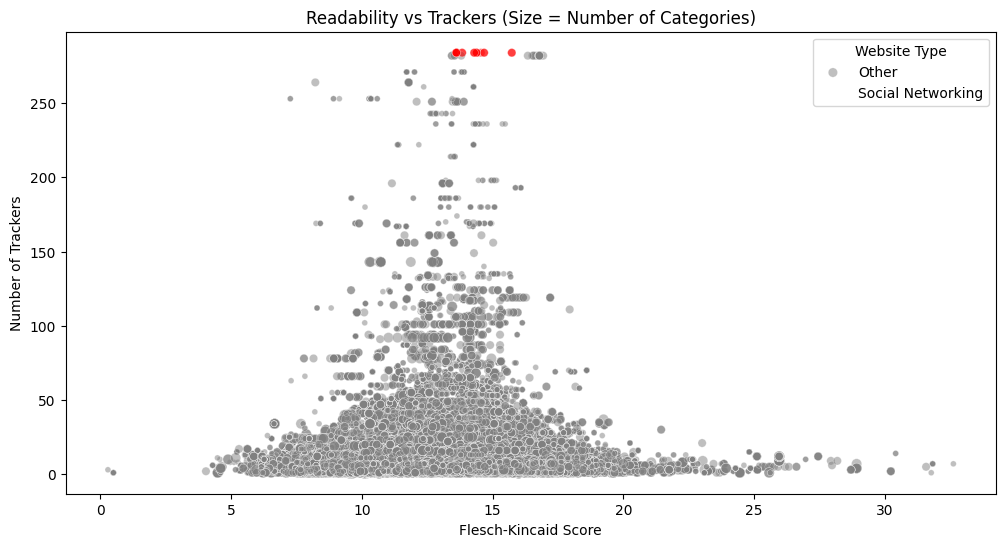

In [33]:
# Count number of categories per website
df_filtered['category_count'] = df_filtered['categories'].str.count(';') + 1

# Create scatter plot with size based on number of categories
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_filtered, 
                x='flesch_kincaid', 
                y='tracker_count',
                hue='is_social',
                size='category_count',
                alpha=0.5,
                palette=['gray', 'red'])

plt.title('Readability vs Trackers (Size = Number of Categories)')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.legend(title='Website Type', labels=['Other', 'Social Networking'])
plt.show()


In [ ]:
# T-test comparing tracker counts between social and non-social
stats.ttest_ind(df_filtered[df_filtered['is_social']]['tracker_count'],
                df_filtered[~df_filtered['is_social']]['tracker_count'])

/tmp/ipykernel_65296/2920689522.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['main_category'] = df_filtered['categories'].apply(categorize_website)


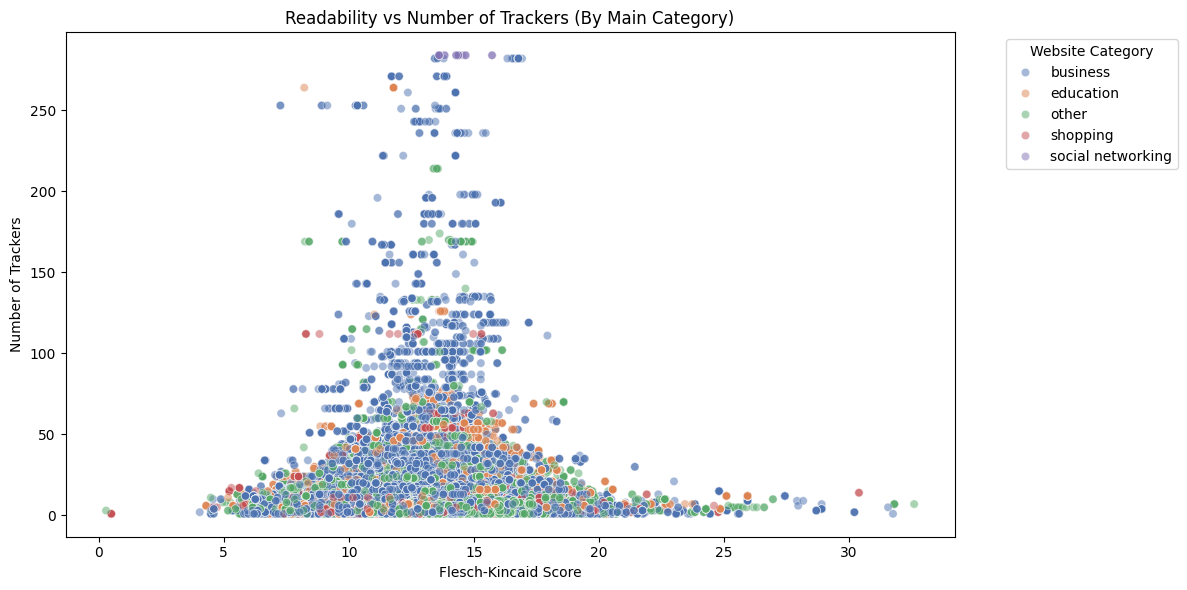


Summary statistics by category:
                  tracker_count                      flesch_kincaid         \
                          count   mean median    std           mean median   
main_category                                                                
business                 447847   6.27    5.0   9.29          12.95  12.92   
education                 96511   7.51    6.0   7.45          12.93  12.89   
other                    187938   6.10    4.0   6.63          12.94  12.87   
shopping                  63528   5.28    4.0   4.95          12.54  12.53   
social networking           275  23.61    4.0  69.15          12.78  12.77   

                         
                    std  
main_category            
business           1.85  
education          1.91  
other              1.89  
shopping           1.79  
social networking  1.90  

Percentage distribution of categories:
business             56.26
other                23.61
education            12.12
shopping     

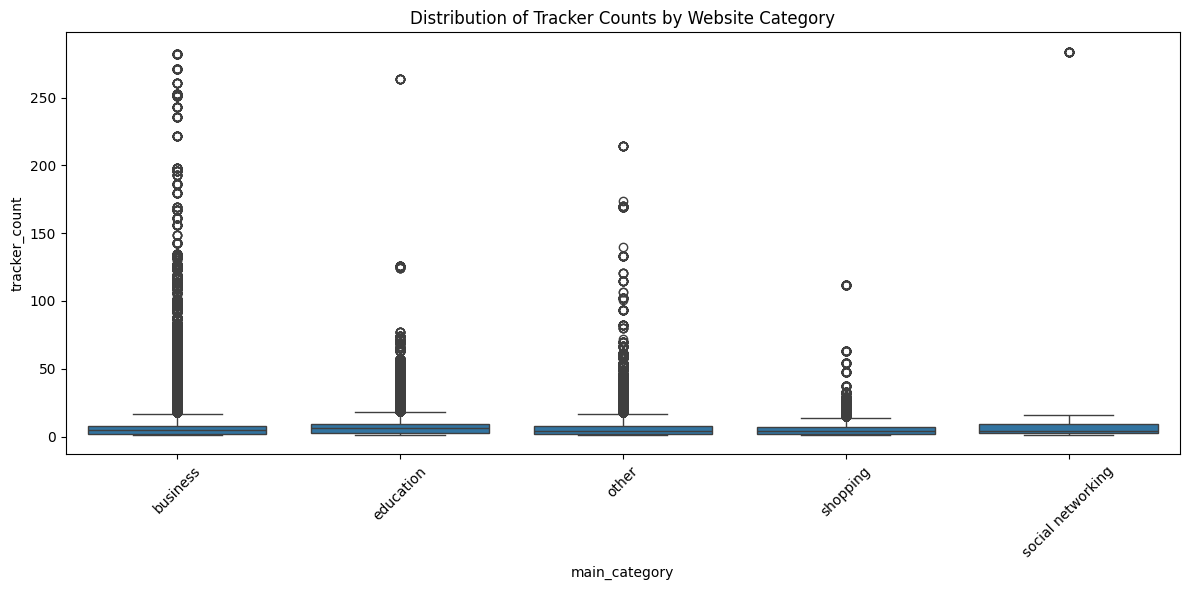

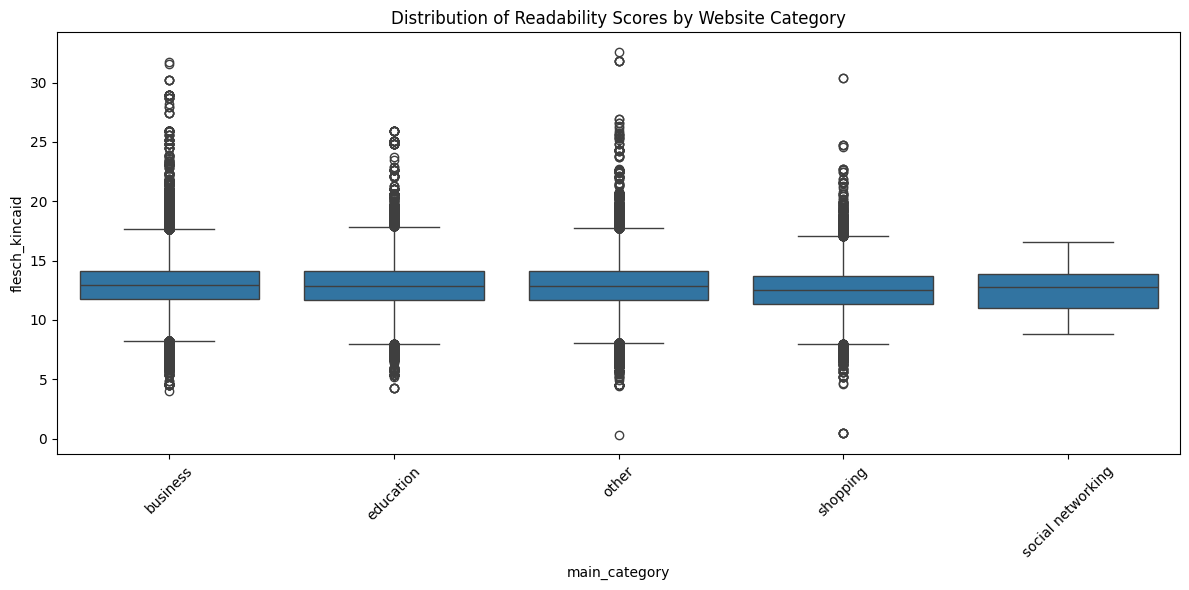

ModuleNotFoundError: No module named 'scipy'

In [34]:
# Function to check if a website belongs to specific categories
def get_website_categories(categories_string):
    if pd.isna(categories_string):
        return []
    return categories_string.lower().split(';')

# Create a function to check multiple categories of interest
def categorize_website(categories_string):
    if pd.isna(categories_string):
        return 'uncategorized'
    
    categories = categories_string.lower().split(';')
    
    # Define categories of interest
    if 'socialnetworking' in categories:
        return 'social networking'
    elif 'business' in categories:
        return 'business'
    elif 'education' in categories:
        return 'education'
    elif 'shopping' in categories:
        return 'shopping'
    else:
        return 'other'

# Apply categorization
df_filtered['main_category'] = df_filtered['categories'].apply(categorize_website)

# Create visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_filtered, 
                x='flesch_kincaid', 
                y='tracker_count',
                hue='main_category',
                alpha=0.5,
                palette='deep')

plt.title('Readability vs Number of Trackers (By Main Category)')
plt.xlabel('Flesch-Kincaid Score')
plt.ylabel('Number of Trackers')
plt.legend(title='Website Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Print statistics by category
print("\nSummary statistics by category:")
summary_stats = df_filtered.groupby('main_category').agg({
    'tracker_count': ['count', 'mean', 'median', 'std'],
    'flesch_kincaid': ['mean', 'median', 'std']
}).round(2)

print(summary_stats)

# Calculate percentage of websites in each category
category_distribution = df_filtered['main_category'].value_counts(normalize=True) * 100
print("\nPercentage distribution of categories:")
print(category_distribution.round(2))

# Optional: Create a box plot to show distribution of trackers by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='main_category', y='tracker_count')
plt.xticks(rotation=45)
plt.title('Distribution of Tracker Counts by Website Category')
plt.tight_layout()
plt.show()

# Optional: Create a box plot for readability scores by category
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='main_category', y='flesch_kincaid')
plt.xticks(rotation=45)
plt.title('Distribution of Readability Scores by Website Category')
plt.tight_layout()
plt.show()

# Test for statistical significance
from scipy import stats

# Perform Kruskal-Wallis H-test
kw_trackers = stats.kruskal(*[group['tracker_count'].values 
                             for name, group in df_filtered.groupby('main_category')])
kw_readability = stats.kruskal(*[group['flesch_kincaid'].values 
                                for name, group in df_filtered.groupby('main_category')])

print("\nKruskal-Wallis H-test results:")
print(f"Tracker count: p-value = {kw_trackers.pvalue:.4f}")
print(f"Readability: p-value = {kw_readability.pvalue:.4f}")


In [36]:
category_stats = df_filtered.groupby('categories').agg({
    'tracker_count': ['count', 'mean', 'median'],
    'flesch_kincaid': 'mean'
}).sort_values(('tracker_count', 'mean'), ascending=False)

print(category_stats.head(10))


                                                tracker_count              \
                                                        count        mean   
categories                                                                  
blogsandpersonal;socialnetworking                          18  284.000000   
messageboardsandforums;newsandmedia                         3   59.000000   
adult;business;informationtech                             37   57.378378   
business;informationtech;messageboardsandforums           179   34.083799   
blogsandpersonal                                          387   22.087855   
economyandfinance;newsandmedia                             39   20.717949   
adult;newsandmedia                                         12   19.000000   
education;searchenginesandportals                          54   16.740741   
advertising;business;education                             28   16.000000   
blogsandpersonal;entertainment;shopping                    19   15.000000   

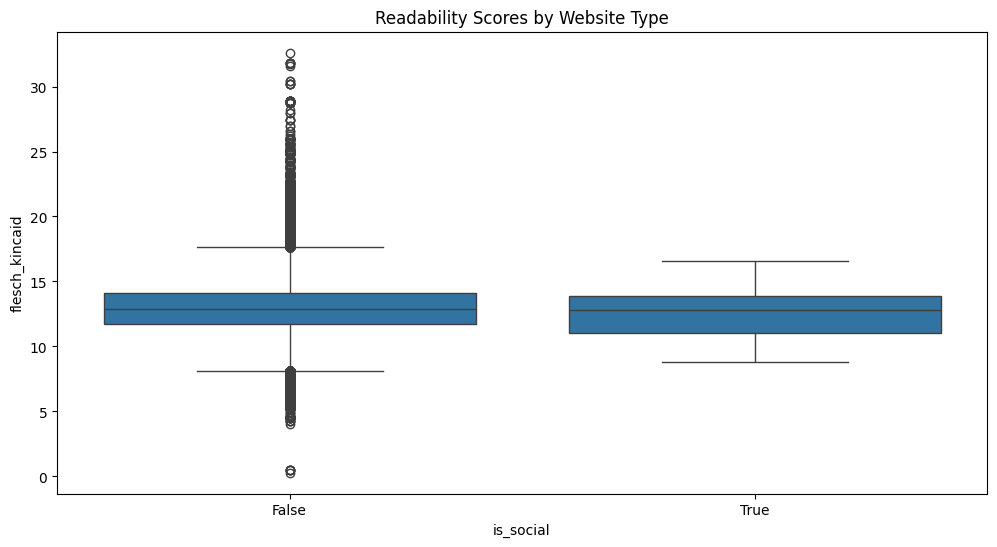

: 

In [ ]:
# Compare readability distributions between social and non-social
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_filtered, x='is_social', y='flesch_kincaid')
plt.title('Readability Scores by Website Type')
plt.show()
